In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
import fates_xarray_funcs
from fates_xarray_funcs import monthly_to_annual



In [3]:
cases_in = {'S0':'f19_0007_trendyS0_39e91e09b5_c2da27fd',
         'S1':'f19_0008_trendyS1_39e91e09b5_c2da27fd',
         'S2':'f19_0010_trendyS2_hybrid_39e91e09b5_c2da27fd',
         'S3':'f19_0009_trendyS3_parta_39e91e09b5_c2da27fd',
         'S3b':'f19_0011_trendyS3_partb_hybrid_39e91e09b5_c2da27fd'}

cases_out = ['S0','S1','S2','S3']

start_year = {'S0':1701,
         'S1':1701,
         'S2':1901,
         'S3':1701,
         'S3b':1901}

base_data_dir = '/global/homes/c/cdkoven/cdkoven_m2467/trendy_2025_tseries_files/'

minlat = -60.

In [4]:
output_vars_list = ['tas', 'pr', 'rsds', 'mrso', 'mrro', 'evapotrans', 'evapo', 'cVeg', 'cLitter', 'cSoil', 'cProduct', 
                    'gpp', 'ra', 'npp', 'rh', 'fFire', 'fLuc', 'soilr', 'nbp', 
                    'landCoverFrac', 'oceanCoverFrac', 'burntArea', 'lai', 
                    'cLeaf', 'cWood', 'cRoot', 'cCwd', 'cSoilpools', 'fVegLitter', 'fLeafLitter', 'fWoodLitter', 
                    'fRootLitter', 'fLitterSoil', 'fVegSoil', 'rhpool', 'fAllocLeaf', 'fAllocWood', 'fAllocRoot', 
                    'fFireCveg', 'fFireLitter', 'fFireCsoil', 'tsl', 'msl', 'evspsblveg', 'evspsblsoi', 'tran', 
                    'fGrazing']

output_pft_vars_list = ['evapotranspft', 'transpft', 'albedopft', 'snow_depthpft', 'shflxpft', 'rnpft',  'cVegpft', 'cSoilpft',
                        'gpppft', 'npppft', 'rhpft', 'nbppft', 'laipft',   'tskinpft', 'mslpft', 'theightpft']

input_vars_list_cfluxes = ['FATES_FRACTION','FATES_GPP','NBP','FATES_NPP','FATES_AUTORESP','HR','FATES_SEEDS_IN_EXTERN_EL','FATES_BURNFRAC','FATES_GRAZING','PRODUCT_CLOSS','FATES_FIRE_CLOSS_LANDUSECHANGE','FATES_FIRE_CLOSS','FATES_FROOTMAINTAR','landfrac','area']
input_vars_list_cpools = ['FATES_FRACTION','PROD100C','PROD10C','TOTLITC','TOTSOMC','FATES_VEGC','FATES_LEAFC','FATES_STRUCTC','FATES_STOREC','FATES_SAPWOODC','FATES_FROOTC','FATES_LITTER_AG_CWD_EL','FATES_LITTER_BG_CWD_EL']
input_vars_list_physvars = ['TSA','RAIN','SNOW','area','FSDS','FCEV','FCTR','FGEV','QRUNOFF','QSOIL','QVEGE','QVEGT','TLAI']
input_vars_list_soilwater = ['SOILICE','SOILLIQ','TSOI']

input_list_pft_allocvars = ['FATES_FRACTION','FATES_AGSAPWOOD_ALLOC_SZPF','FATES_AGSTRUCT_ALLOC_SZPF','FATES_BGSAPWOOD_ALLOC_SZPF','FATES_BGSTRUCT_ALLOC_SZPF','FATES_FROOT_ALLOC_SZPF','FATES_LEAF_ALLOC_SZPF']

input_list_pft_phys_pftvars = ['FATES_FRACTION','FATES_SHFLUX_PF','FATES_LHFLUX_PF','FATES_NETLW_PF','FATES_SWABS_PF','FSDS']
input_list_pft_carbonvars = ['FATES_NOCOMP_PATCHAREA_PF','FATES_GPP_PF','FATES_NPP_PF','FATES_VEGC_PF']

input_list_landcoverfracvars = ['FATES_FRACTION','FATES_NOCOMP_PATCHAREA_PF','landfrac']

In [5]:
unitslist = ['K','kg m-2 s-1','W m-2','kg m-2','fraction','m m-2','m','1']

units_conversions = {'gC/m^2/s':['kg m-2 s-1', 1e-3],
                     'mm/s':['kg m-2 s-1', 1.],
                     'W/m^2':['W m-2',1.],
                     'kg/m2':['kg m-2',1.],
                     'gC/m^2':['kg m-2', 1e-3],
                     'm2 m-2':['fraction', 1.],
}

fates_pftname=["broadleaf_evergreen_tropical_tree","needleleaf_evergreen_extratrop_tree",
               "needleleaf_colddecid_extratrop_tree","broadleaf_evergreen_extratrop_tree",
               "broadleaf_hydrodecid_troical_tree","broadleaf_colddecid_extratrop_tree",
               "broadleaf_evergreen_extratrop_shrub","broadleaf_hydrodecid_extratrop_shrub",
               "broadleaf_colddecid_extratrop_shrub","broadleaf_evergreen_arctc_shrub",
               "broadleaf_colddecid_arctic_shrub","arctic_c3_grass","cool_c3_grass","c4_grass"]


In [6]:
def gettime():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.%f")

def inherit_attrs(parents):
    attrs = parents[0].attrs
    for parent in parents[1:]:
        attrs.update({key: value for (key, value) in parent.attrs.items() if 'history_' in key})
    return attrs
        
class datadict(dict):
    def getdata(self, varname, cases_in=cases_in, cases_out=cases_out, start_year=start_year, base_data_dir=base_data_dir):
        fins = {}
        dataarrays_out = {}
        for case_in in cases_in:
            fins[case_in] = xr.open_dataset(base_data_dir+cases_in[case_in]+'/'+cases_in[case_in]+'.tseries.'+varname+'.nc')#, chunks={"time": 10})
            ### for the special case of _SCPF variables, just drop the size class dimension on read to reduce memory cost
            if "fates_levscpf" in fins[case_in][varname].dims:
                attrs = inherit_attrs(fins[case_in][varname])
                fins[case_in] = fates_xarray_funcs.scpf_to_scls_by_pft(fins[case_in][varname], fins[case_in]).sum(dim='fates_levscls').rename(varname).to_dataset()
                fins[case_in][varname].attrs = attrs
        for case_out in cases_out:
            if case_out in ['S0','S1'] or 'time' not in fins[case_out][varname].dims:
                dataset_out = fins[case_out]
            elif case_out == 'S2':
                s2a = fins['S1'].isel(time=slice(0,200*12))
                s2b = fins['S2']
                dataset_out = xr.concat((s2a,s2b), dim='time')
            elif case_out == 'S3':
                s3a = fins['S3'].isel(time=slice(0,200*12))
                s3b = fins['S3b']
                dataset_out = xr.concat((s3a,s3b), dim='time')
            dataset_out['time'] = np.arange(len(dataset_out['time']))/12.+1701.
            dataset_out = dataset_out.sel(lat=slice(minlat,90.))
            if "fates_levelem" in dataset_out[varname].dims:
                dataset_out = dataset_out.isel(fates_levelem=0).squeeze()
                dataset_out.drop_vars('fates_levelem')
            dataarrays_out.update({case_out:dataset_out[varname]})
        self.update({varname:dataarrays_out})

    def fates_frac_scale(self, varname):
        dataarrays_out = {}
        if varname[0:6] == 'FATES_':
            newvarname = varname[6:]
        else:
            raise Exception
        for case in self[varname]:
            scaledvar = self[varname][case] * self['FATES_FRACTION'][case]
            scaledvar.attrs = inherit_attrs((self[varname][case],))
            scaledvar = scaledvar.rename(newvarname)
            scaledvar.attrs['history_'+gettime()] = newvarname + ' = ' + varname + ' * FATES_FRACTION'
            dataarrays_out[case] = scaledvar
        self.update({newvarname:dataarrays_out})

    def writedata(self, varname, output_data_dir=base_data_dir+'/postprocessed/', model_name='ELM-FATES'):
        for case_out in self[varname]:
            if self[varname][case_out].attrs['units'] not in unitslist:
                print('need to fix units')
                print(varname,case_out,self[varname][case_out].attrs['units'])
                raise Exception
            if 'fates_levpft' in self[varname][case_out].dims:
                for i, pft, in enumerate(fates_pftname):
                    self[varname][case_out].attrs['PFT_'+str(i+1).zfill(2)+'_name'] = pft
            #try:
            self[varname][case_out].to_netcdf(output_data_dir+model_name+'_'+case_out+'_'+varname+'.nc', format="NETCDF4_CLASSIC", engine='netcdf4', encoding={varname:{"zlib": True,"complevel":1}})
            #except:
                #self[varname][case_out].to_netcdf(output_data_dir+'ELM-FATES_'+case_out+'_'+varname+'.nc', format="NETCDF4_CLASSIC", engine='netcdf4')

    def rename(self, oldvarname, newvarname):
        self[newvarname] = {}
        for case in self[oldvarname]:
            self[newvarname][case] = self[oldvarname][case].rename(newvarname)
            self[newvarname][case].attrs = inherit_attrs(self[oldvarname][case])
            self[newvarname][case].attrs['history_'+gettime()] = newvarname + ' = ' + oldvarname

    def addvars(self, listofvarnames, newvarname):
        self[newvarname] = {}
        for case in self[listofvarnames[0]]:
            attrs = inherit_attrs(self[listofvarnames[0]][case])
            newvar = self[listofvarnames[0]][case]
            newvar.attrs = attrs
            for var in listofvarnames[1:]:
                if newvar.attrs['units'] != self[var][case].attrs['units']:
                    print("units need to match for vars "+var + " and others in list: " + ", ".join(listofvarnames) )
                    print(newvar.attrs['units'])
                    print(self[var][case].attrs['units'])
                    raise Exception
                attrs = inherit_attrs((newvar, self[var][case]))
                newvar = newvar + self[var][case]
                newvar.attrs = attrs
            newvar = newvar.rename(newvarname)
            newvar.attrs['long_name'] = newvarname
            newvar.attrs['history_'+gettime()] = newvarname + ' = ' + ' + '.join(listofvarnames)
            self[newvarname][case]  = newvar

    def check_units(self):
        for var in self:
            for case in self[var]:
                if self[var][case].attrs['units'] not in unitslist:
                    print(var,case,self[var][case].attrs['units'])

    def fix_units(self, varname):
        for case in self[varname]:
            if self[varname][case].attrs['units'] in unitslist:
                print('no need to convert units for variable '+varname + 'with units: ' + self[varname][case].attrs['units'])
            else:
                if self[varname][case].attrs['units'] in units_conversions:
                    newunits, scale = units_conversions[self[varname][case].attrs['units']]
                    oldunits = self[varname][case].attrs['units']
                    attrs = inherit_attrs(self[varname][case])
                    self[varname][case] = self[varname][case] * scale
                    self[varname][case].attrs = attrs
                    self[varname][case].attrs['units'] = newunits
                    self[varname][case].attrs['history_'+gettime()] = 'unit conversion on '+varname+' of '+str(scale)+' from: '+ oldunits + ' to: ' + newunits
                else:
                    print('units not in conversion list: '+self[varname][case].attrs['units'])
                    raise Exception

    def vertical_sum(self,varname):
        newvarname = 'TOT'+varname
        self[newvarname] = {}
        for case in self[varname]:
            newvar = self[varname][case].sum(dim='levgrnd')
            newvar = newvar.rename(newvarname)
            newvar.attrs = inherit_attrs(self[varname][case])
            newvar.attrs['history_'+gettime()] = newvarname + ' = levgrnd sum of '+varname
            self[newvarname][case]  = newvar

    def concat_maps_along_expdim(self, varname, tstart, tend):
        outputdata = []
        for exp in self[varname]:
            outputdata.append(monthly_to_annual(self[varname][exp].sel(time=slice(tstart,tend))).mean(dim='time'))
        newda = xr.concat(outputdata,dim='exp')
        return newda

    def pftfrac_scale(self, varname, newvarname):
        dataarrays_out = {}
        for case in self[varname]:
            scaledvar = self[varname][case] / self['FATES_NOCOMP_PATCHAREA_PF'][case]
            scaledvar.attrs = inherit_attrs((self[varname][case],))
            scaledvar = scaledvar.rename(newvarname)
            scaledvar.attrs['history_'+gettime()] = newvarname + ' = ' + varname + ' / FATES_NOCOMP_PATCHAREA_PF'
            dataarrays_out[case] = scaledvar
        self.update({newvarname:dataarrays_out})

    def construct_landcoverfrac_var(self):
        ## need a special variable called 'landcoverfrac'. should sum to landfrac.
        ## each PFT 1-n = FATES_FRACTION * FATES_NOCOMP_PATCHAREA_PF(:) * landfrac
        ## make PFT 0 that is ( (1 - sum(FATES_NOCOMP_PATCHAREA_PF))*FATES_FRACTION + (1-FATES_FRACTION) )*landfrac
        dataarrays_out = {}
        for case in self['FATES_NOCOMP_PATCHAREA_PF']:
            nonpft_landcoverfrac = ((1. - self['FATES_NOCOMP_PATCHAREA_PF'][case].sum(dim='fates_levpft') * self['FATES_FRACTION'][case]) + (1.- self['FATES_FRACTION'][case]))* self['landfrac'][case]
            nonpft_landcoverfrac = nonpft_landcoverfrac.expand_dims(dim={'fates_levpft':np.arange(1)})
            pfts_landcoverfrac = self['FATES_FRACTION'][case] * self['FATES_NOCOMP_PATCHAREA_PF'][case] * self['landfrac'][case]
            landcoverfrac = xr.concat((nonpft_landcoverfrac,pfts_landcoverfrac), dim='fates_levpft')
            landcoverfrac.attrs = inherit_attrs((self['FATES_NOCOMP_PATCHAREA_PF'][case],))
            landcoverfrac = landcoverfrac.rename('landcoverfrac')
            landcoverfrac.attrs['history_'+gettime()] = 'landcoverfrac[PFT 0] represents all non-PFT occupied area, so bare ground plus inland waters, etc.'
            landcoverfrac.attrs['history_'+gettime()] = 'landcoverfrac[PFT 0] =  (1 - sum(FATES_NOCOMP_PATCHAREA_PF[:]))*FATES_FRACTION + (1-FATES_FRACTION) )*landfrac'
            landcoverfrac.attrs['history_'+gettime()] = 'landcoverfrac[PFTs 1:] = FATES_FRACTION * FATES_NOCOMP_PATCHAREA_PF[:] * landfrac'
            dataarrays_out[case] = landcoverfrac
        self.update({'landcoverfrac':dataarrays_out})

    def construct_oceancoverfrac_var(self):
        dataarrays_out = {}
        for case in self['landfrac']:
            oceancoverfrac = (1.-self['landfrac'][case])
            oceancoverfrac.attrs = inherit_attrs((self['landfrac'][case],))
            oceancoverfrac.attrs['units'] = 'fraction'
            oceancoverfrac = oceancoverfrac.rename('oceancoverfrac')
            dataarrays_out[case] = oceancoverfrac
        self.update({'oceancoverfrac':dataarrays_out})
    
    def calc_albedo(self, swinvar, swabsvar, albvarname):
        dataarrays_out = {}
        for case in self[swinvar]:
            albedo = (1.-self[swabsvar][case])/ self[swinvar][case]
            albedo.attrs = inherit_attrs((self[swinvar][case],))
            albedo.attrs['units'] = 'fraction'
            albedo.attrs['long_name'] = 'SW albedo by PFT (all-sky)'
            albedo.attrs['history_'+gettime()] = albvarname + ' = (1 - ' + swabsvar + ') / '+ swinvar
            albedo = albedo.rename(albvarname)
            dataarrays_out[case] = albedo
        self.update({albvarname:dataarrays_out})
        

In [7]:
#input_list_pft_phys_pftvars = ['FATES_FRACTION','FATES_SHFLUX_PF','FATES_LHFLUX_PF','FATES_NETLW_PF','FATES_SWABS_PF','FSDS']

varblock = datadict()
for var in input_list_pft_phys_pftvars:
    varblock.getdata(var)

varblock.rename('FATES_LHFLUX_PF','evapotranspft')
varblock.writedata('evapotranspft')

varblock.addvars(('FATES_NETLW_PF','FATES_SWABS_PF'), 'rnpft')
varblock.writedata('rnpft')

varblock.calc_albedo('FSDS', 'FATES_SWABS_PF', 'albedopft')
varblock.writedata('albedopft')

In [8]:
varblock = datadict()
for var in input_list_landcoverfracvars:
    varblock.getdata(var)

varblock.construct_landcoverfrac_var()
varblock.fix_units('landcoverfrac')
varblock.writedata('landcoverfrac')

varblock.construct_oceancoverfrac_var()
varblock.writedata('oceancoverfrac')

In [9]:
varblock = datadict()

#for var in ['FATES_NOCOMP_PATCHAREA_PF','FATES_GPP_PF','FATES_NPP_PF']:

for var in input_list_pft_carbonvars:
    varblock.getdata(var)

varblock.pftfrac_scale('FATES_GPP_PF', 'gpppft')
varblock.writedata('gpppft')

varblock.pftfrac_scale('FATES_NPP_PF', 'npppft')
varblock.writedata('npppft')

varblock.pftfrac_scale('FATES_VEGC_PF', 'cVegpft')
varblock.writedata('cVegpft')


In [10]:
varblock = datadict()

for var in input_vars_list_cpools:
    varblock.getdata(var)

varblock.addvars(['PROD100C','PROD10C'],'cProduct')
varblock.fix_units('cProduct')
varblock.writedata('cProduct')

varblock.addvars(['TOTLITC','TOTSOMC'],'cSoil')
varblock.fix_units('cSoil')
varblock.writedata('cSoil')

varblock.fates_frac_scale('FATES_VEGC')
varblock.rename('VEGC','cVeg')
varblock.writedata('cVeg')

varblock.fates_frac_scale('FATES_LEAFC')
varblock.rename('LEAFC','cLeaf')
varblock.writedata('cLeaf')

varblock.fates_frac_scale('FATES_STRUCTC')
varblock.fates_frac_scale('FATES_SAPWOODC')
varblock.addvars(['STRUCTC','SAPWOODC'],'cWood')
varblock.writedata('cWood')

varblock.fates_frac_scale('FATES_LITTER_AG_CWD_EL')
varblock.fates_frac_scale('FATES_LITTER_BG_CWD_EL')
varblock.addvars(['LITTER_AG_CWD_EL','LITTER_BG_CWD_EL'],'cCwd')
varblock.writedata('cCwd')


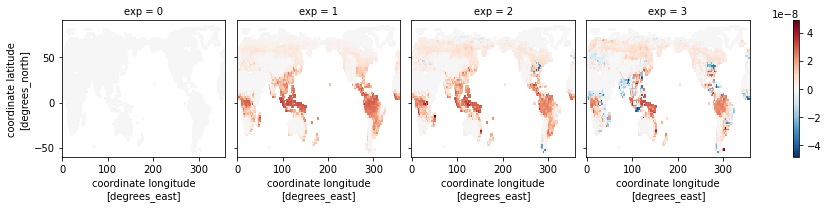

In [12]:
varblock = datadict()

for var in input_vars_list_cfluxes:
    varblock.getdata(var)

#varblock.check_units()

varblock.fates_frac_scale('FATES_SEEDS_IN_EXTERN_EL')
varblock.fix_units('NBP')
varblock.addvars(['NBP','SEEDS_IN_EXTERN_EL'],'nbp')
varblock.writedata('nbp')

varblock.fates_frac_scale('FATES_GPP')
varblock.rename('GPP','gpp')
varblock.writedata('gpp')

gpp_final = varblock.concat_maps_along_expdim('FATES_GPP',2000.,2024)
(gpp_final - gpp_final[0,:,:]).plot(x='lon',y='lat',col='exp')

varblock.fates_frac_scale('FATES_NPP')
varblock.rename('NPP','npp')
varblock.writedata('npp')

varblock.fates_frac_scale('FATES_AUTORESP')
varblock.rename('AUTORESP','ra')
varblock.writedata('ra')

varblock.rename('HR','rh')
varblock.fix_units('rh')
varblock.writedata('rh')

varblock.fates_frac_scale('FATES_FROOTMAINTAR')
varblock.addvars(['rh','FROOTMAINTAR'],'soilr')
varblock.writedata('soilr')

varblock.fates_frac_scale('FATES_GRAZING')
varblock.rename('GRAZING','fGrazing')
varblock.writedata('fGrazing')

varblock.fix_units('PRODUCT_CLOSS')
varblock.fates_frac_scale('FATES_FIRE_CLOSS_LANDUSECHANGE')
varblock.addvars(['fGrazing','PRODUCT_CLOSS','FIRE_CLOSS_LANDUSECHANGE'],'fLuc')
varblock.writedata('fLuc')

varblock.fates_frac_scale('FATES_FIRE_CLOSS')
varblock.rename('FIRE_CLOSS','fFire')
varblock.writedata('fFire')

S0
S1
S2
S3


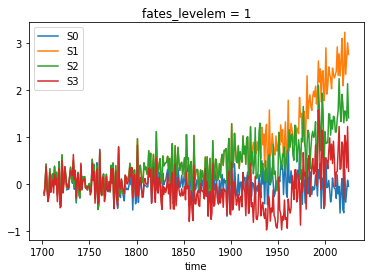

In [61]:
region_latbands = {"Global":[-90.,90.],"South":[-90.,-30.],"Tropics":[-30.,30.],"North":[30.,90.]}


for scenario in cases_out:
    print(scenario)
    global_nbp = (monthly_to_annual(varblock['nbp'][scenario].sel(lat=slice(region_latbands["Global"][0],region_latbands["Global"][1]))) * varblock['area'][scenario].sel(lat=slice(region_latbands["Global"][0],region_latbands["Global"][1])) * varblock['landfrac'][scenario].sel(lat=slice(region_latbands["Global"][0],region_latbands["Global"][1]))).sum(dim=('lat','lon'))*86400*365 * 1e6 / 1e12
    south_nbp = (monthly_to_annual(varblock['nbp'][scenario].sel(lat=slice(region_latbands["South"][0],region_latbands["South"][1]))) * varblock['area'][scenario].sel(lat=slice(region_latbands["South"][0],region_latbands["South"][1])) * varblock['landfrac'][scenario].sel(lat=slice(region_latbands["South"][0],region_latbands["South"][1]))).sum(dim=('lat','lon'))*86400*365 * 1e6 / 1e12
    tropics_nbp = (monthly_to_annual(varblock['nbp'][scenario].sel(lat=slice(region_latbands["Tropics"][0],region_latbands["Tropics"][1]))) * varblock['area'][scenario].sel(lat=slice(region_latbands["Tropics"][0],region_latbands["Tropics"][1])) * varblock['landfrac'][scenario].sel(lat=slice(region_latbands["Tropics"][0],region_latbands["Tropics"][1]))).sum(dim=('lat','lon'))*86400*365 * 1e6 / 1e12
    north_nbp = (monthly_to_annual(varblock['nbp'][scenario].sel(lat=slice(region_latbands["North"][0],region_latbands["North"][1]))) * varblock['area'][scenario].sel(lat=slice(region_latbands["North"][0],region_latbands["North"][1])) * varblock['landfrac'][scenario].sel(lat=slice(region_latbands["North"][0],region_latbands["North"][1]))).sum(dim=('lat','lon'))*86400*365 * 1e6 / 1e12
    year = global_nbp.time.astype(int).rename('Year')
    dataout = xr.merge([year.to_dataset(), global_nbp.rename('Global').to_dataset(), north_nbp.rename('North').to_dataset(), tropics_nbp.rename('Tropics').to_dataset(), south_nbp.rename('South').to_dataset()]).to_dataframe()
    dataout = dataout.drop("fates_levelem", axis=1)
    dataout.to_csv('ELM-FATES_'+region+'.csv', index=False)
    global_nbp.plot(label=scenario)
plt.legend()
    


In [63]:
varblock = datadict()

for var in input_vars_list_physvars:
    varblock.getdata(var)

varblock.addvars(['RAIN','SNOW'],'pr')
varblock.fix_units('pr')
varblock.writedata('pr')

varblock.rename('TSA', 'tas')
varblock.writedata('tas')

varblock.rename('FSDS', 'rsds')
varblock.fix_units('rsds')
varblock.writedata('rsds')

varblock.rename('QRUNOFF', 'mrro')
varblock.fix_units('mrro')
varblock.writedata('mrro')

varblock.addvars(['QVEGT','QVEGE','QSOIL'],'evapotrans')
varblock.fix_units('evapotrans')
varblock.writedata('evapotrans')

varblock.rename('TLAI', 'lai')
varblock.writedata('lai')

varblock.rename('QVEGT', 'tran')
varblock.fix_units('tran')
varblock.writedata('tran')

varblock.rename('QVEGE', 'evspsblveg')
varblock.fix_units('evspsblveg')
varblock.writedata('evspsblveg')

varblock.rename('QSOIL', 'evspsblsoi')
varblock.fix_units('evspsblsoi')
varblock.writedata('evspsblsoi')

In [65]:
varblock = datadict()

for var in input_vars_list_soilwater:
    varblock.getdata(var)

varblock.vertical_sum('SOILICE')
varblock.vertical_sum('SOILLIQ')
varblock.addvars(['TOTSOILLIQ','TOTSOILICE'],'mrso')
varblock.fix_units('mrso')
varblock.writedata('mrso')

varblock.addvars(['SOILLIQ','SOILICE'],'mls')
varblock.fix_units('mls')
varblock.writedata('mls')

varblock.rename('TSOI', 'tsl')
varblock.writedata('tsl')

In [7]:
varblock = datadict()

input_list_pft_allocvars = ['FATES_AGSAPWOOD_ALLOC_SZPF','FATES_AGSTRUCT_ALLOC_SZPF','FATES_BGSAPWOOD_ALLOC_SZPF','FATES_BGSTRUCT_ALLOC_SZPF','FATES_FROOT_ALLOC_SZPF','FATES_LEAF_ALLOC_SZPF']


for var in input_list_pft_allocvars:
    varblock.getdata(var)

varblock.addvars(['FATES_AGSAPWOOD_ALLOC_SZPF','FATES_AGSTRUCT_ALLOC_SZPF'],'fAllocWood')
varblock.writedata('fAllocWood')

varblock.rename('FATES_LEAF_ALLOC_SZPF','fAllocLeaf')
varblock.writedata('fAllocLeaf')

varblock.addvars(['FATES_BGSAPWOOD_ALLOC_SZPF','FATES_BGSTRUCT_ALLOC_SZPF','FATES_FROOT_ALLOC_SZPF'],'fAllocRoot')
varblock.writedata('fAllocRoot')
